# Q7: How does CCM responds to different levels of shortcut?

I expect only std to be affected by it

In [2]:
import sys, os
import tqdm
import numpy as np
import seaborn as sns
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from torchvision import transforms
from IPython.display import Image as showImg
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Subset
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from copy import deepcopy
import matplotlib
import pandas as pd
from sklearn.metrics import average_precision_score
from torchvision.transforms import GaussianBlur, CenterCrop, ColorJitter, Grayscale, RandomCrop, RandomHorizontalFlip

###
if '../' not in sys.path:
    sys.path = ['../'] + sys.path
from lib.models import MLP
from lib.data import small_CUB, CUB, SubColumn, CUB_test_transform, CUB_train_transform, shortcut_noise_transform
from lib.train import train
from lib.eval import get_output, test, plot_log, shap_net_x, shap_ccm_c, bootstrap
from lib.utils import birdfile2class, birdfile2idx, is_test_bird_idx, get_bird_bbox, get_bird_class, get_bird_part, get_part_location, get_multi_part_location, get_bird_name
from lib.utils import get_attribute_name, code2certainty, get_class_attributes, get_image_attributes, describe_bird

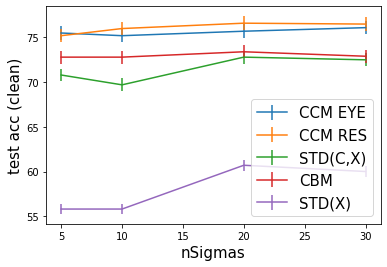

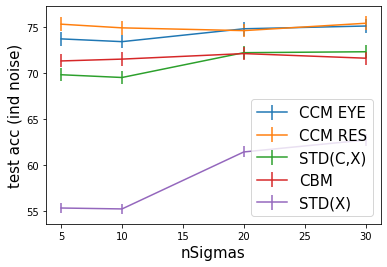

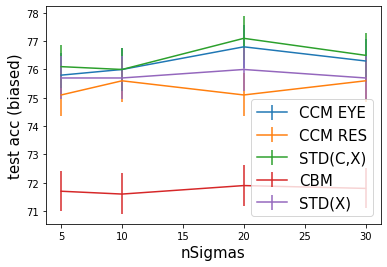

In [41]:
# key is n_shortcuts, value is [clean acc, t=0, t=1]
perf_dict_cbm = {
#    1: [73.6, 73.6, 73.6],
    5: [72.8, 71.3, 71.7],
    10: [72.8, 71.5, 71.6],
    20: [73.4, 72.1, 71.9], 
    30: [72.9, 71.6, 71.8] 
}
perf_dict_eye = { # currently only tried 1e-3
#     1: [],
    5: [75.5, 73.7, 75.8],
    10: [75.2, 73.4, 76.0],
    20: [75.7, 74.8, 76.8],
    30: [76.1, 75.1, 76.3],
}
perf_dict_stdcx = { # eye with alpha=0
#     1: [],
    5: [70.8, 69.8, 76.1],
    10: [69.7, 69.5, 76.0], 
    20: [72.8, 72.2, 77.1],
    30: [72.5, 72.3, 76.5],
}
perf_dict_stdx = {
#    1: [80.5, 80.5, 80.5],
    5: [55.8, 55.3, 75.7],
    10: [55.8, 55.2, 75.7], 
    20: [60.7, 61.4, 76.0],
    30: [60.0, 62.7, 75.7],
}
perf_dict_ccmr = {
#    1: [],
    5: [75.2, 75.3, 75.1], # 74.4
    10: [76.0, 74.9, 75.6],
    20: [76.6, 74.6, 75.1],
    30: [76.5, 75.4, 75.6],
}
perf_dict_stdcx_ugrad = {
    1: [78.0, 78.0, 78.0],
    5: [75.4, 73.9, 75.4],
    10: [73.5, 72.8, 74.9],
    20: [74.1, 73.2, 74.7],
    30: [75.9, 74.8, 75.8],
}

def get_error(p, n=100):
    '''bootstrap'''
    assert 0 <= p <= 1, "probablity is non-negative"
    n_test = 5790 # number of test data in cub
    a, b = np.percentile([sum(np.random.choice(2, n_test, p=[1-p, p])) / float(n_test) for _ in range(n)], [2.5, 97.5])
    return a, b

def plot_d_noise(d, dim=0, label=None):
    x = d.keys()
    y = list(map(lambda x: x[dim], d.values()))
    # plt.plot(x, y, label=label)
    yerr = list(zip(*[get_error(a/100.0) for a in y]))
    plt.errorbar(x, y, yerr=yerr, label=label)
    
xlabel = "nSigmas" # (larger the more informative)"

plot_d_noise(perf_dict_eye, 0, "CCM EYE")
plot_d_noise(perf_dict_ccmr, 0, "CCM RES")
plot_d_noise(perf_dict_stdcx, 0, "STD(C,X)")
plot_d_noise(perf_dict_cbm, 0, "CBM")
plot_d_noise(perf_dict_stdx, 0, "STD(X)")
plt.ylabel('test acc (clean)', fontsize=15)
plt.xlabel(xlabel, fontsize=15)
plt.legend(fontsize=15)
plt.savefig('figures/clean_ns_cub.png')
plt.show()

plot_d_noise(perf_dict_eye, 1, "CCM EYE")
plot_d_noise(perf_dict_ccmr, 1, "CCM RES")
plot_d_noise(perf_dict_stdcx, 1, "STD(C,X)")
plot_d_noise(perf_dict_cbm, 1, "CBM")
plot_d_noise(perf_dict_stdx, 1, "STD(X)")
plt.ylabel('test acc (ind noise)', fontsize=15)
plt.xlabel(xlabel, fontsize=15)
plt.legend(fontsize=15)
plt.savefig('figures/ind_ns_cub.png')
plt.show()

plot_d_noise(perf_dict_eye, 2, "CCM EYE")
plot_d_noise(perf_dict_ccmr, 2, "CCM RES")
plot_d_noise(perf_dict_stdcx, 2, "STD(C,X)")
plot_d_noise(perf_dict_cbm, 2, "CBM")
plot_d_noise(perf_dict_stdx, 2, "STD(X)")
plt.ylabel('test acc (biased)', fontsize=15)
plt.xlabel(xlabel, fontsize=15)
plt.legend(fontsize=15)
plt.savefig('figures/bias_ns_cub.png')
plt.show()

The jump in 0 is because linspace(0,0.1,1) will give 0, which means no noise added, making the problem easier. STD clean performance increases because larger nSigmas, the harder to learn/utilize the shortcut.

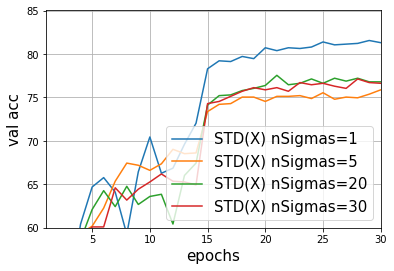

In [17]:
key = 'val acc'
plot_log(torch.load("../outputs/00042e18136e11ecb773ac1f6b24a434/standard.log"), key=key, label="STD(X) nSigmas=1")
plot_log(torch.load("../outputs/a18625a6137911ecb773ac1f6b24a434/standard.log"), key=key, label="STD(X) nSigmas=5")
plot_log(torch.load("../outputs/30d45682138511ecb773ac1f6b24a434/standard.log"), key=key, label="STD(X) nSigmas=20")
plot_log(torch.load("../outputs/ffad38a6139011ecb773ac1f6b24a434/standard.log"), key=key, label="STD(X) nSigmas=30")

plt.xlim([1, 30])
plt.ylim(60)
plt.grid()
plt.legend(fontsize=15)
plt.ylabel(key)
plt.show()